In [39]:
# Imports
import pymc as pm
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Set seed
np.random.seed(1)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [loc, scale]
>Metropolis: [df]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([[<Axes: title={'center': 'loc'}>, <Axes: title={'center': 'loc'}>],
       [<Axes: title={'center': 'df'}>, <Axes: title={'center': 'df'}>],
       [<Axes: title={'center': 'scale'}>,
        <Axes: title={'center': 'scale'}>]], dtype=object)

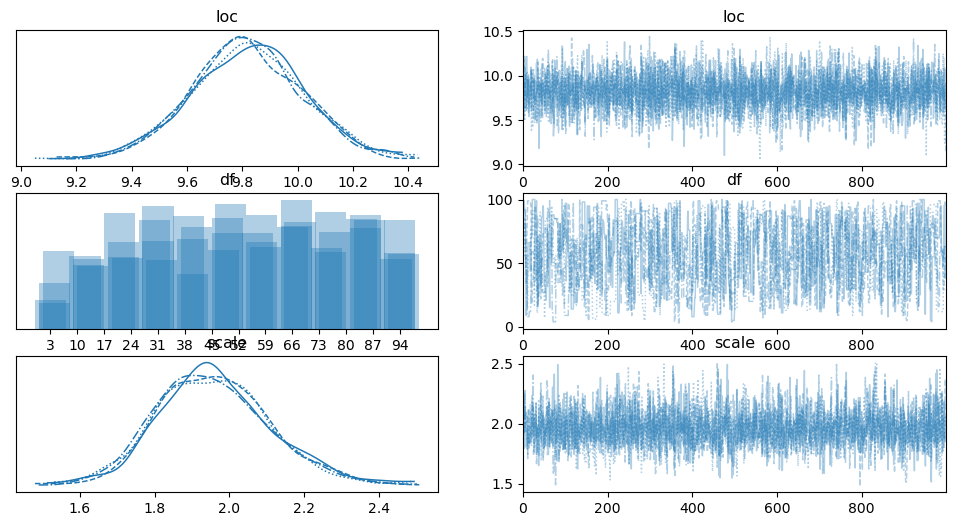

In [6]:
n, loc_true, scale_true, df_true = 100, 10, 2, 15
x = stats.t(df = df_true, loc = loc_true, scale = scale_true).rvs(n)

model = pm.Model()
with model:
  loc = pm.Normal("loc", mu=0, sigma=10)
  scale = pm.HalfNormal("scale", sigma=5)
  df = pm.DiscreteUniform("df", lower=1, upper=100)
  x_obs = pm.StudentT("likelihood", mu=loc, sigma=scale, nu=df, observed=x)

with model:
  idata=pm.sample()

import arviz as az
az.plot_trace(idata)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [loc, scale]
>Metropolis: [df]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


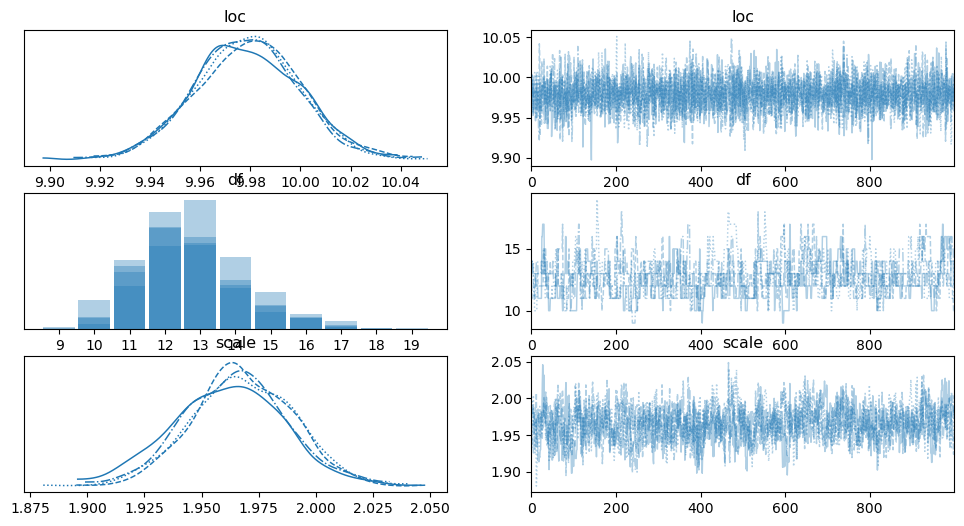

In [16]:
n,loc_true,scale_true,df_true = 10000,10,2,15 
x = stats.t(df = df_true, loc = loc_true, scale = scale_true).rvs(n) 

with pm.Model() as t_norm_half_norm_discrete: 
    loc = pm.Normal("loc", mu=0, sigma=10)
    scale = pm.HalfNormal("scale", sigma=5)
    df = pm.DiscreteUniform("df", lower=1,upper=100)
    x_obs = pm.StudentT("likelihood", mu=loc, sigma=scale, nu=df, observed=x)
    idata = pm.sample()
    
import arviz as az; az.plot_trace(idata);

# Part 1:
We can see that as the sample size increases, from 100 to 10000, the distribution of the data becomes a lot more clear. The variance is also shown to decrease. However, another increase in sample size may result in a more clear distribution and one that is closer to the true distribution; we see that the mean is centered at around 14 but the true mean is 15. 

# Part 2:

## a)

As shown in part 1 we observed a more distribution when increasing the sample size, thus we can conclude that an increase in sample size will result in a more clear distribution. 

## b)

The effective sample size per chain is smaller than 100 for some parameters indicating that the MCMC sampling may not have explored the parameter space sufficiently, and the estimates for those parameters may be less reliable.

## c)

Divergence is 0 thus the sampler is able to explore the posterior. 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, tau, theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, tau, theta_t]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Effective Sample Sizes (function of Markov Chain autocorrelation dependency)


,Centered,Non-Centered
mu,742.0,11904.0
tau,60.0,5956.0
theta[0],1179.0,9879.0
theta[1],1366.0,11655.0
theta[2],1754.0,10704.0
theta[3],1808.0,11938.0
theta[4],1724.0,12008.0
theta[5],1960.0,11047.0
theta[6],1087.0,10834.0
theta[7],1947.0,10959.0


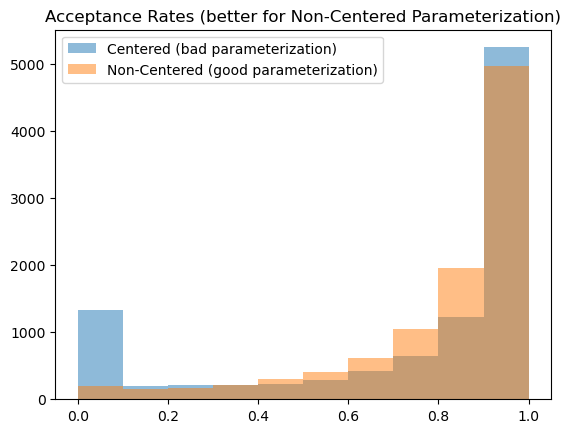

In [40]:
import numpy as np 
SEED = [20100420, 20134234]
J = 8 
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]) 
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])
with pm.Model() as Centered_eight:
    mu = pm.Normal("mu", mu=0, sigma=5) 
    tau = pm.HalfCauchy("tau", beta=5) 
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J)   
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

with Centered_eight: fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED, return_inferencedata=True, idata_kwargs={"log_likelihood": True})
with pm.Model() as NonCentered_eight: 
    mu = pm.Normal("mu", mu=0, sigma=5) 
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    theta = pm.Deterministic("theta", mu + tau * theta_tilde)  
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)
with NonCentered_eight: fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED, return_inferencedata=True, idata_kwargs={"log_likelihood": True})
plt.hist(fit_C.sample_stats.acceptance_rate.values.flatten(), alpha=0.5, label='Centered (bad parameterization)'); 
plt.hist(fit_NC.sample_stats.acceptance_rate.values.flatten(), alpha=0.5, label='Non-Centered (good parameterization)');
plt.title('Acceptance Rates (better for Non-Centered Parameterization)'); 
plt.legend();    

print("Effective Sample Sizes (function of Markov Chain autocorrelation dependency)") 
pd.concat( [pd.DataFrame({'Centered': pm.summary(fit_C)[:1]['ess_bulk'], 
                          'Non-Centered': pm.summary(fit_NC)['ess_bulk'][:1]}),
            pd.DataFrame({'Centered': pm.summary(fit_C)[1:]['ess_bulk'], 
                          'Non-Centered': pm.summary(fit_NC)['ess_bulk'][9:]})])



The "uncentered" parameterization in Hamiltonian Monte Carlo (HMC) performs better than the "centered" version by aligning the parameter space with directions of lower correlation.

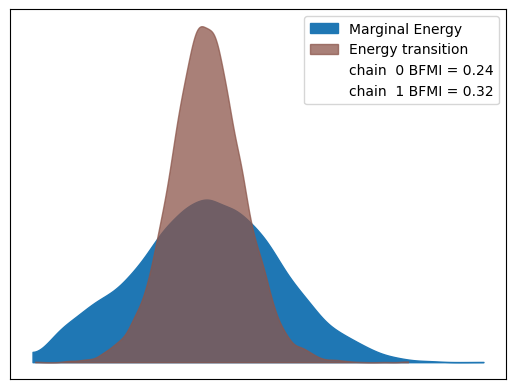

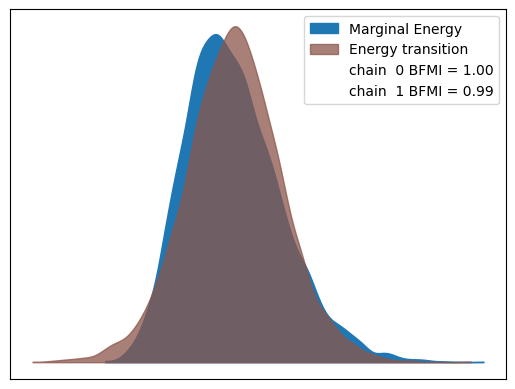

In [41]:
az.plot_energy(fit_C);
az.plot_energy(fit_NC);

The diagnostic plot shows that the "non-centered" model has a better overlap of energy distributions compared to the "centered" model. This backs up my earlier point that the "non-centered" setup is more effective for the Hamiltonian Monte Carlo sampler. 